# Análisis zonal de cambios urbanos – Pudahuel (2017–2024)

Este notebook implementa el análisis zonal de los cambios urbanos detectados en la comuna de Pudahuel,
utilizando una grilla regular como unidad espacial de análisis.

Se calculan, por zona:
- Porcentaje de pérdida significativa de vegetación (ΔNDVI < -0.2)
- Porcentaje de aumento significativo de áreas construidas (ΔNDBI > 0.2)

Los resultados se exportan como tabla CSV y sirven de base para mapas coropléticos
y análisis de patrones espaciales.



In [15]:
import geopandas as gpd
import rasterio
import rasterio.mask   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely.geometry as geom



In [10]:
import os

PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)

print("Directorio de trabajo:", os.getcwd())

Directorio de trabajo: /home/diego/Escritorio/GEOLABANTES/Lab2DV


In [6]:
# Área de estudio (WGS84)
xmin, ymin, xmax, ymax = -70.78, -33.46, -70.60, -33.33


In [7]:
cell_size = 0.0045  # ~500 metros

polygons = []
ids = []

x_coords = np.arange(xmin, xmax, cell_size)
y_coords = np.arange(ymin, ymax, cell_size)

cell_id = 0
for x in x_coords:
    for y in y_coords:
        poly = geom.box(x, y, x + cell_size, y + cell_size)
        polygons.append(poly)
        ids.append(cell_id)
        cell_id += 1

grid = gpd.GeoDataFrame(
    {"zone_id": ids},
    geometry=polygons,
    crs="EPSG:4326"
)

grid.head()


,zone_id,geometry
0,0,"POLYGON ((-70.7755 -33.46, -70.7755 -33.4555, ..."
1,1,"POLYGON ((-70.7755 -33.4555, -70.7755 -33.451,..."
2,2,"POLYGON ((-70.7755 -33.451, -70.7755 -33.4465,..."
3,3,"POLYGON ((-70.7755 -33.4465, -70.7755 -33.442,..."
4,4,"POLYGON ((-70.7755 -33.442, -70.7755 -33.4375,..."


In [8]:
grid.to_file("data/processed/grilla_pudahuel.gpkg", driver="GPKG")


In [11]:
delta_ndvi_path = "data/processed/delta_ndvi_2017_2024.tif"
delta_ndbi_path = "data/processed/delta_ndbi_2017_2024.tif"

ndvi_src = rasterio.open(delta_ndvi_path)
ndbi_src = rasterio.open(delta_ndbi_path)


In [12]:
def zonal_percentage(raster, zones, threshold, mode="less"):
    results = []

    for _, row in zones.iterrows():
        geom_zone = [row.geometry]

        out_image, _ = rasterio.mask.mask(
            raster, geom_zone, crop=True, filled=False
        )
        data = out_image[0]
        data = data[~np.isnan(data)]

        if data.size == 0:
            results.append(0)
            continue

        if mode == "less":
            pct = np.sum(data < threshold) / data.size * 100
        else:
            pct = np.sum(data > threshold) / data.size * 100

        results.append(pct)

    return results


In [16]:
grid["perc_loss_veg"] = zonal_percentage(
    ndvi_src, grid, threshold=-0.2, mode="less"
)

grid["perc_gain_built"] = zonal_percentage(
    ndbi_src, grid, threshold=0.2, mode="greater"
)

grid.head()


,zone_id,geometry,perc_loss_veg,perc_gain_built
0,0,"POLYGON ((-70.7755 -33.46, -70.7755 -33.4555, ...",0.076894,0.000000
1,1,"POLYGON ((-70.7755 -33.4555, -70.7755 -33.451,...",1.076509,0.115340
2,2,"POLYGON ((-70.7755 -33.451, -70.7755 -33.4465,...",4.767397,1.999231
3,3,"POLYGON ((-70.7755 -33.4465, -70.7755 -33.442,...",0.230681,0.538255
4,4,"POLYGON ((-70.7755 -33.442, -70.7755 -33.4375,...",0.038447,0.269127


In [17]:
df = grid[["zone_id", "perc_loss_veg", "perc_gain_built"]]
df.to_csv("outputs/cambios_por_zona_pudahuel.csv", index=False)

df.describe()


,zone_id,perc_loss_veg,perc_gain_built
count,1189.000000,1189.000000,1189.000000
mean,594.000000,2.231703,2.542020
std,343.379042,8.076514,8.189166
min,0.000000,0.000000,0.000000
25%,297.000000,0.075415,0.038447
50%,594.000000,0.307574,0.499808
75%,891.000000,1.114956,1.845444
max,1188.000000,96.078431,96.116878


In [18]:
grid.to_file("data/processed/cambios_por_zona.gpkg", driver="GPKG")


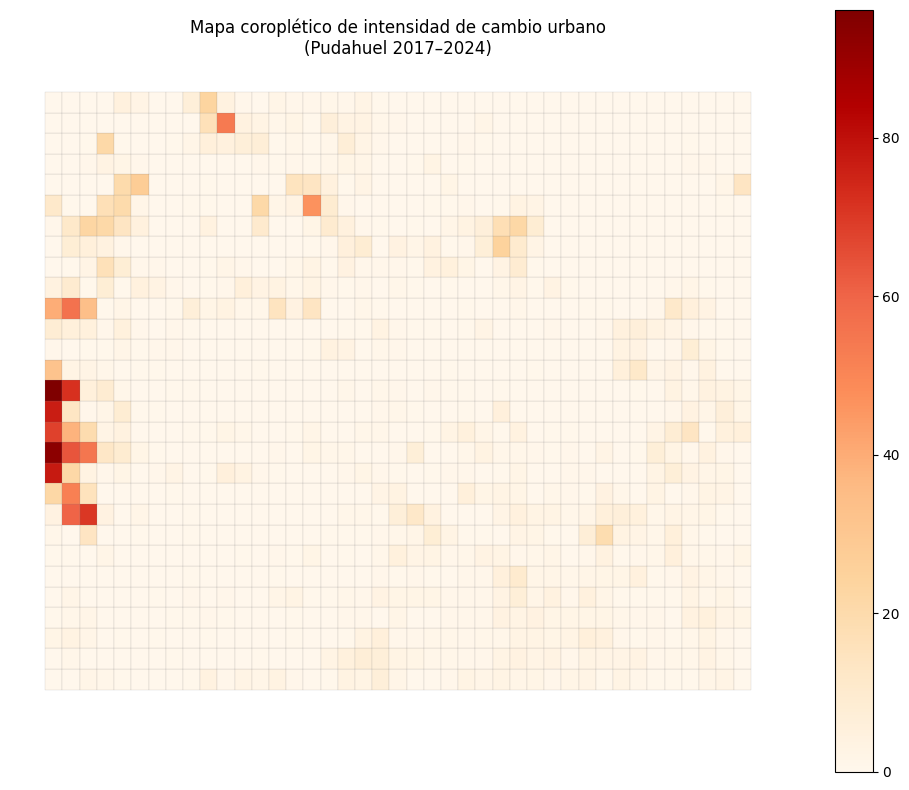

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

grid.plot(
    column="perc_gain_built",
    cmap="OrRd",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    ax=ax
)

ax.set_title(
    "Mapa coroplético de intensidad de cambio urbano\n(Pudahuel 2017–2024)",
    fontsize=12
)
ax.axis("off")

plt.tight_layout()
plt.savefig(
    "outputs/figures/mapa_coropletico_cambio.png",
    dpi=300
)
plt.show()
